## Segmentação de Clientes de Cartão de Crédito

Neste notebook faremos uma análise de cluster sobre os dados de diversos clientes que possuem cartão de crédito. 

O objetivo da análise de cluster é agrupar as observações em grupos de tal forma que dentro de cada grupo as
observações são semelhantes e distintas entre os grupos.

Nesse sentido, busca-se identificar diferentes perfis de consumidores, entender suas necessidades e traçar diferentes estratégias para cada grupo.

As variáveis consideradas na análise serão:
> O saldo em conta

> A frequência que o saldo é atualizado

> O valor em compras no cartão

> A maior compra registrada

> Frequência com que as compras acontecem

Os dados foram extraídos do kaggle através do link: https://www.kaggle.com/arjunbhasin2013/ccdata

### Introdução

In [25]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [73]:
# Importando os dados, ajustando o índice e removendo algumas variáveis
dados = pd.read_csv('credit_card_data.csv').set_index('CUST_ID').drop(['INSTALLMENTS_PURCHASES',
                                                                       'CASH_ADVANCE',
                                                                       'ONEOFF_PURCHASES_FREQUENCY',
                                                                       'PURCHASES_INSTALLMENTS_FREQUENCY',
                                                                       'CASH_ADVANCE_TRX','PURCHASES_TRX',
                                                                       'PAYMENTS','PRC_FULL_PAYMENT',
                                                                       'TENURE', 'CREDIT_LIMIT',
                                                                      'MINIMUM_PAYMENTS',
                                                                      'CASH_ADVANCE_FREQUENCY'], axis=1)
# Ajustando o nome das variáveis
dados.rename(mapper={'BALANCE':'SALDO_CONTA',
                    'BALANCE_FREQUENCY':'FREQ_ATUALIZ_SALDO',
                    'PURCHASES':'COMPRAS',
                    'ONEOFF_PURCHASES':'MAIOR_COMPRA',
                    'PURCHASES_FREQUENCY':'FREQ_COMPRAS'}, axis=1, inplace=True)


print('Total de linhas: {}'.format(dados.shape[0]))
print('Total de colunas: {}'.format(dados.shape[1]))

# Visualizando 5 amostras aleatórias do dataset
round(dados.sample(5), 2)

Total de linhas: 8950
Total de colunas: 5


,SALDO_CONTA,FREQ_ATUALIZ_SALDO,COMPRAS,MAIOR_COMPRA,FREQ_COMPRAS
CUST_ID,,,,,
C14052,95.60,1.00,101.97,101.97,0.25
C11351,1172.34,1.00,454.21,0.00,0.92
C10582,5484.80,1.00,0.00,0.00,0.00
C18587,10.40,0.45,533.98,293.98,0.50
C10094,6110.27,1.00,0.00,0.00,0.00


In [3]:
# Avaliando se existem dados faltantes
dados.isnull().sum()

SALDO_CONTA           0
FREQ_ATUALIZ_SALDO    0
COMPRAS               0
MAIOR_COMPRA          0
FREQ_COMPRAS          0
dtype: int64

In [4]:
# Removendo amostras que possuem valores faltantes
dados.dropna(inplace=True)
dados.isnull().sum()

SALDO_CONTA           0
FREQ_ATUALIZ_SALDO    0
COMPRAS               0
MAIOR_COMPRA          0
FREQ_COMPRAS          0
dtype: int64

### Análise Exploratória

In [5]:
# Estatísticas Descritivas sobre as variáveis
round(dados.describe(),2)

,SALDO_CONTA,FREQ_ATUALIZ_SALDO,COMPRAS,MAIOR_COMPRA,FREQ_COMPRAS
count,8950.00,8950.00,8950.00,8950.00,8950.00
mean,1564.47,0.88,1003.20,592.44,0.49
std,2081.53,0.24,2136.63,1659.89,0.40
min,0.00,0.00,0.00,0.00,0.00
25%,128.28,0.89,39.64,0.00,0.08
50%,873.39,1.00,361.28,38.00,0.50
75%,2054.14,1.00,1110.13,577.41,0.92
max,19043.14,1.00,49039.57,40761.25,1.00


Em média cada cliente possui 1564,47 reais na conta, porém 50% possuem menos de 900 reais.

Em média cada cliente possui 1003,20 reais em compras no cartão, porém 50% possuem menos de 370 reais
e 25% possuem menos de 40,00 reais.

A maior compra foi de 40761,25 reais, porém 25% dos clientes não fizeram nenhuma compra até o momento.

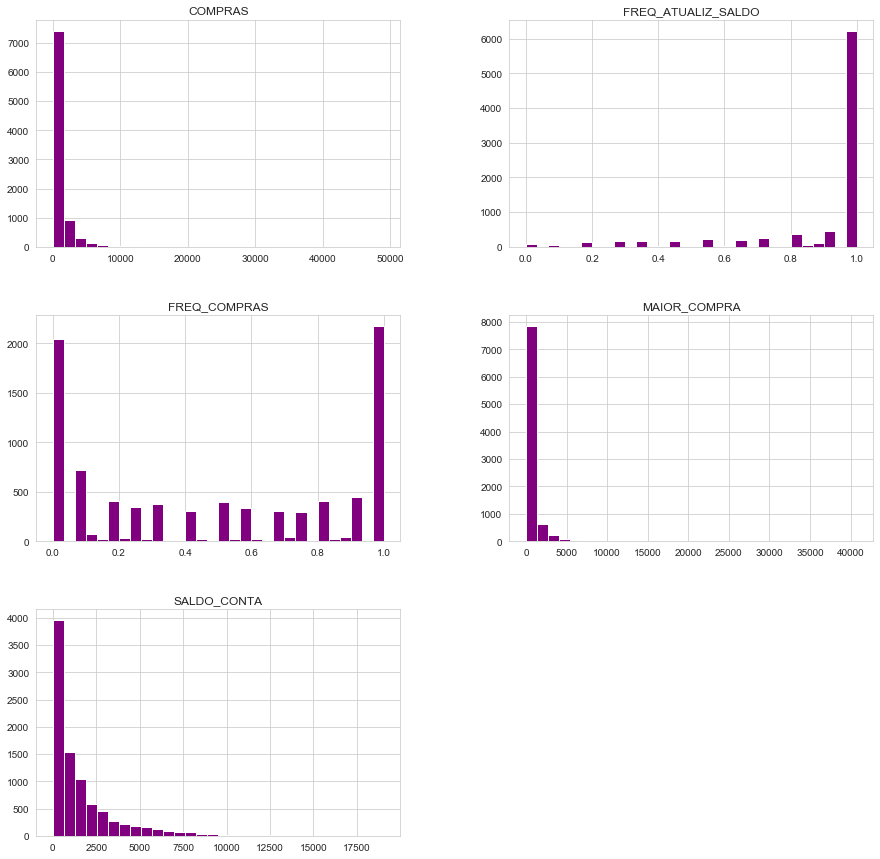

In [6]:
# Visualizando a distribuição das variáveis
dados.hist(color = 'purple', figsize=(15,15), bins=30)
plt.show()

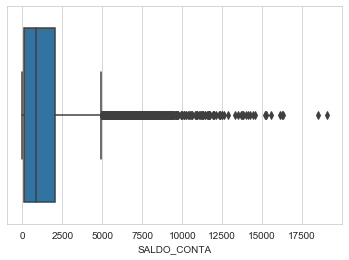

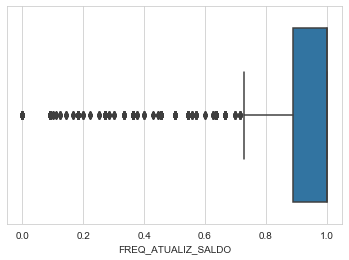

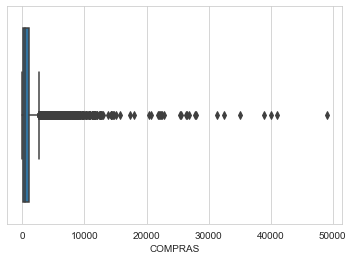

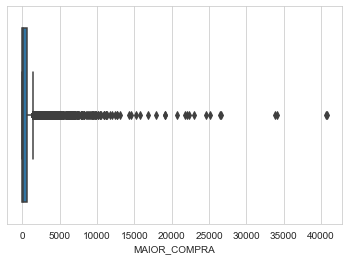

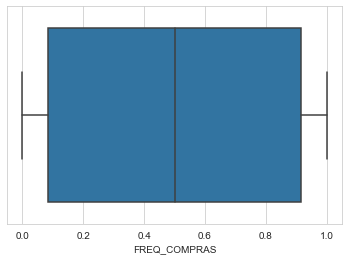

In [7]:
# Análise de outliers nas variáveis
for i in dados.describe().columns:
    sns.boxplot(dados[i])
    plt.show()

É possível constatar que existem diversos outliers nas variáveis explicativas, ou seja, os dados são muito diversos entre si.

Um dos objetivos da análise de cluster é a possibilidade de identificar, organizar e visualizar diferentes cenários/perfis de clientes para que assim se possa traçar estratégias direcionadas para cada grupo analisado.

Além disso, os insights dessa análise podem favorecer uma análise supervisionada, como por exemplo de regressão linear, em que uma vez que temos os dados agrupados por similaridade, se torna mais interessante treinar um modelo de machine learning direcionado para cada grupo, em vez de um único modelo para todo o conjunto de dados, incluindo os outliers.

Neste sentido, as previsões devem ser pautadas de forma que não ocorra a extrapolação dos dados em cada variável.

### Análise de Clusters

In [8]:
# Padronizando os dados
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(dados)

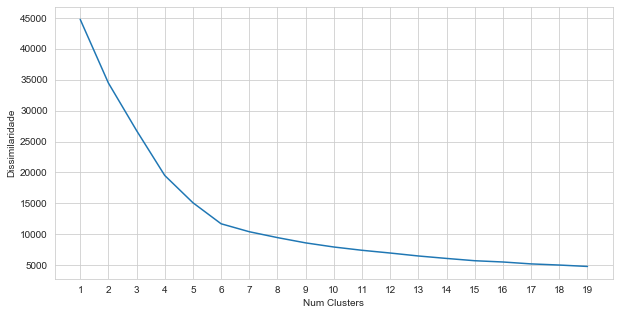

In [9]:
# Definindo a quantidade ideal de clusters pelo método Elbow
tx = []
for i in range (1,20):
    kmeans = KMeans(i)
    kmeans.fit(dados_padronizados)
    tx.append(kmeans.inertia_)
    
plt.figure(figsize = [10, 5])
plt.plot(range(1,20), tx)
plt.xticks(range(1,20))
plt.xlabel('Num Clusters')
plt.ylabel('Dissimilaridade')
plt.show()

Neste sentido, entendemos que 6 grupos seria a quantidade mais interessante, uma vez que a partir daí a dissimilaridade não tem grandes quedas. Entretanto vale ressaltar que a quantidade de grupos depende fortemente do objetivo do problema que está sendo resolvido.

In [10]:
# Instanciando o modelo
kmeans = KMeans(6)
kmeans.fit(dados_padronizados)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
# Analisando o centros de cada grupo (média de cada variável no grupo)
centroides = round(pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=dados.columns),2)

In [17]:
# visualizando os grupos ordenados pela frequência de compras
centroides.sort_values('FREQ_COMPRAS')

,SALDO_CONTA,FREQ_ATUALIZ_SALDO,COMPRAS,MAIOR_COMPRA,FREQ_COMPRAS
3,1469.02,0.97,194.42,155.64,0.12
0,149.38,0.38,351.87,195.68,0.28
1,6448.32,0.99,742.42,397.21,0.36
2,866.55,0.97,1169.52,533.81,0.87
4,5601.64,0.95,28394.16,22858.46,0.90
5,2836.94,0.98,6277.49,4452.84,0.91


Neste ponto podemos separar estes 6 grupos em 2, aqueles com baixa frequência de compras, grupos 0, 1 e 3, e aqueles com alta frequência de compras, grupos 2, 4 e 5. Chamaremos de grupo A e B, respectivamente.

In [18]:
# Visualizando o grupo A
centroides[centroides.index.isin([0,1,3])]

,SALDO_CONTA,FREQ_ATUALIZ_SALDO,COMPRAS,MAIOR_COMPRA,FREQ_COMPRAS
0,149.38,0.38,351.87,195.68,0.28
1,6448.32,0.99,742.42,397.21,0.36
3,1469.02,0.97,194.42,155.64,0.12


Analisando o grupo A, percebemos que o Grupo 0 é composto por clientes com baixo saldo em conta, baixa frequência de atualização desse saldo e com média de compras de 350 reais.

Os grupos 1 e 3 possuem maiores valores de saldo em conta e alta freqûencia de atualização desse saldo, ou seja, como são clientes que compram pouco, então podem ser clientes que recebem muito nessa conta. 

Além disso, o grupo 1 possui maiores valores de compra e saldo em conta em relação ao grupo 3.

A partir desse ponto, podemos traçar duas estratégias. A primeira é realizar um estudo de caso com ferramentas de BI para entender o histórico de cada perfil, produtos, consumo, preferncias, planos de serviços, etc, para entender melhor cada cenário. A segunda é criar campanhas de marketing e estratégias comerciais a partir do perfil de cada grupo, de acordo com a forma com que se deseja impactar cada tipo de cliente.

Por exemplo, o grupo 0 que movimenta pouco a conta e compra pouco, podemos realizar um campanha para que ele comece a realizar mais movimentações com essa conta e futuramente realizar mais compras com o cartão.

Os grupos 1 e 3 já movimentam bem a conta, porém precisamos de campanhas para que esses clientes passem  a utilizar mais o cartão de crédito para aumentar a frequência de compra, se esse for o objetivo comercial.

In [19]:
# Visualizando o grupo B
centroides[centroides.index.isin([2,4,5])]

,SALDO_CONTA,FREQ_ATUALIZ_SALDO,COMPRAS,MAIOR_COMPRA,FREQ_COMPRAS
2,866.55,0.97,1169.52,533.81,0.87
4,5601.64,0.95,28394.16,22858.46,0.90
5,2836.94,0.98,6277.49,4452.84,0.91


Analisando o grupo B, percebemos que são clientes que movimentam a conta com frequência e também realizam compras com frequência. Entretanto se diferenciam nos valores, sendo o grupo 4 o mais forte em relação a valores. 

Nesse sentido, as estratégias comerciais precisam ser diferentes das adotadas para o grupo A.
Uma vez que estes clients já possuem índicadores "ideais", podemos trabalhar com campanhas de fidelidade do cliente, para que não sejam perdidos ao longo do tempo.

Além disso, também é importante realizar um projeto de BI para entender os serviços adotados por esses clientes e o porquê de serem "clientes de sucesso".

In [22]:
# Adicionando o grupo de cada observação no dataset orginal
dados['CLUSTER'] = kmeans.labels_

# Analisando a quantidade de clientes em cada grupo
dados.CLUSTER.value_counts()

2    3375
3    2914
0    1391
1     810
5     438
4      22
Name: CLUSTER, dtype: int64

Analisando a frequência absoluta de clientes por grupo, percebemos que o grupo 2 é aquele que possui a maior quantidade de clientes. 

São clientes com média de saldo em conta de 870 reais, saldo atualizado frequentemente, compras realizadas frequentemente, Valor médio de compra no cartão de 1000 reais.

Entretanto o grupo "forte" que observamos anteriormente, grupo 4, possui apenas 22 clientes nessa categoria, sendo o menor grupo de todos. 

Isso nos faz pensar se é interessante investir em outros grupos com potencial para se tornarem grupo 4.

## Visualização Gráfica

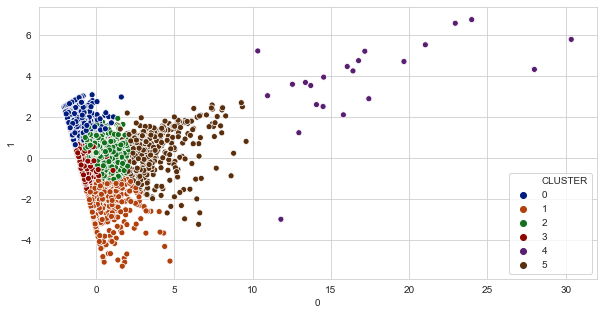

In [72]:
# Redução de dimensionalidade por PCA e visualização dos grupos formados
pca = PCA(n_components=2)
componentes = pd.DataFrame(pca.fit_transform(dados_padronizados))
componentes['CLUSTER'] = kmeans.labels_
plt.figure(figsize=[10, 5])
sns.scatterplot(componentes[0], componentes[1],
                hue = componentes.CLUSTER, palette=sns.color_palette('dark',6))
plt.show()